For this project, first I will create a class and in this class I will put all function I need for implementation of LIF, ALIF and AELIF

In [4]:
# add all library I need in this project
import math
import numpy as np
import matplotlib.pyplot as plt

In [18]:
class LIFS:

  # function for drawing a u / time plot
  def plot_volt_trace(self, v, sp):
    # call all variables we need and define them on local variable
    pars = self.default_pars()
    V_th = pars['V_th']
    dt, range_t = pars['dt'], pars['range_t']
    plt.figure(figsize=(8, 4))
    if sp.size:
      sp_num = (sp / dt).astype(int) - 1
      v[sp_num] += 20 

    # settings of plot
    plt.plot(pars['range_t'], v, 'b')
    plt.axhline(V_th, 0, 1, color='k', ls='--')
    plt.xlabel('Time (ms)')
    plt.ylabel('V (mV)')
    plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
               loc=[1.05, 0.75])
    plt.ylim([-80, -20])


  # function for define parameters we need in this project
  def default_pars(self):
    pars = {}
    pars['V_th'] = -45.     # spike threshold 
    pars['V_reset'] = -69.  # reset potential 
    pars['tau_m'] = 8.     # membrane time constant 
    pars['g_L'] = 10.       # leak conductance 
    pars['V_rest'] = -79.   # restial potential
    pars['tref'] = 0.       # refractory time 
    pars['T'] = 100.  # Total duration of simulation 
    pars['dt'] = .03125   # Simulation time step 
    pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points 

    # For ALIF
    pars['a'] = .1
    pars['b'] = .01
    pars['tau_w'] = 3.  # membrane time constant 
    pars['R'] = .04  # Resistance we use

    # for AELIF
    pars['delta'] = 2000.

    return pars

  # Implementation of LIF
  def LIF(self, Iinj1):
    pars = self.default_pars()

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_rest = pars['V_rest']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']

    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_rest

    # Set current time course

    if isinstance(Iinj1, int):
      Iinj = Iinj1 * np.ones(Lt)
    else:
      Iinj = Iinj1(range_t)

    # Loop over time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration

    for it in range(Lt - 1):

      if tr > 0:  # check if in refractory period
        v[it] = V_reset  # set voltage to reset
        tr = tr - 1 # reduce running counter of refractory period

      elif v[it] >= V_th:  # if voltage over threshold
        rec_spikes.append(it)  # record spike event
        v[it] = V_reset  # reset voltage
        tr = tref / dt  # set refractory time

      # Calculate the increment of the membrane potential
      dv = (Iinj[it] / g_L - (v[it] - V_rest)) * dt / tau_m

      # Update the membrane potential
      v[it + 1] = v[it] + dv

    # Get spike times in ms
    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes


  # Implementation of ALIF
  def ALIF(self, Iinj1):
    pars = self.default_pars()

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_rest = pars['V_rest']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']
    R = pars['R']
    w = np.zeros(Lt)

    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_rest

    # Set current time course

    if isinstance(Iinj1, int):
      Iinj = Iinj1 * np.ones(Lt)
    else:
      Iinj = Iinj1(range_t)

    # Loop over time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration



    for it in range(1, Lt):
      # calculate weight function for this spike
      w[it] = self.calc_w(pars, v[it - 1], it, w[it - 1])
      if tr > 0:  # check if in refractory period
        v[it - 1] = V_reset  # set voltage to reset
        tr = tr - 1 # reduce running counter of refractory period

      elif v[it - 1] >= V_th:  # if voltage over threshold
        rec_spikes.append(it)  # record spike event
        v[it - 1] = V_reset  # reset voltage
        tr = tref / dt  # set refractory time

      # Calculate the increment of the membrane potential
      dv = (Iinj[it] * R - (v[it - 1] - V_rest) - R * w[it]) * dt / tau_m

      # Update the membrane potential
      v[it] = v[it - 1] + dv

    # Get spike times in ms
    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes

  # Implementation of AELIF
  def AELIF(self, Iinj1):
    pars = self.default_pars()

    # Set parameters
    V_th, V_reset = pars['V_th'], pars['V_reset']
    tau_m, g_L = pars['tau_m'], pars['g_L']
    V_rest = pars['V_rest']
    dt, range_t = pars['dt'], pars['range_t']
    Lt = range_t.size
    tref = pars['tref']
    R = pars['R']
    w = np.zeros(Lt)
    delta = pars['delta']

    # Initialize voltage
    v = np.zeros(Lt)
    v[0] = V_rest

    # Set current time course

    if isinstance(Iinj1, int):
      Iinj = Iinj1 * np.ones(Lt)
    else:
      Iinj = Iinj1(range_t)

    # Loop over time
    rec_spikes = []  # record spike times
    tr = 0.  # the count for refractory duration



    for it in range(1, Lt):
      # calculate weight function for this spike
      w[it] = self.calc_w(pars, v[it - 1], it, w[it - 1])
      if tr > 0:  # check if in refractory period
        v[it - 1] = V_reset  # set voltage to reset
        tr = tr - 1 # reduce running counter of refractory period

      elif v[it - 1] >= V_th:  # if voltage over threshold
        rec_spikes.append(it)  # record spike event
        v[it - 1] = V_reset  # reset voltage
        tr = tref / dt  # set refractory time

      # Calculate the increment of the membrane potential
      dv = (Iinj[it] * R - (v[it - 1] - V_rest) - R * w[it] + delta * np.exp((v[it - 1] - V_th)/delta)) * dt / tau_m

      # Update the membrane potential
      v[it] = v[it - 1] + dv

    # Get spike times in ms
    rec_spikes = np.array(rec_spikes) * dt

    return v, rec_spikes

  # calculate weigth of each spike
  def calc_w(self, pars, v, i, w):
    # Calculate the increment of the membrane weight
    dw = (pars['a'] * (v - pars['V_rest']) - w + pars['b'] * pars['tau_w'] *
          self.sigmoid(pars['range_t'][i - 1])) * pars['dt'] / pars['tau_w']
    return w + dw

  # Use sigmoid as function of weight increment
  def sigmoid(self, t):
    return 1 / (1 + math.exp(-t))

In [19]:
# Create a LIF object class
LIF = LIFS()
# Simulate LIF model
v, sp = LIF.LIF(2000)
print(v, sp)

[-79.         -78.21875    -77.44055176 ... -45.32629561 -69.
 -68.2578125 ] [ 1.5      2.59375  3.6875   4.78125  5.875    6.96875  8.0625   9.15625
 10.25    11.34375 12.4375  13.53125 14.625   15.71875 16.8125  17.90625
 19.      20.09375 21.1875  22.28125 23.375   24.46875 25.5625  26.65625
 27.75    28.84375 29.9375  31.03125 32.125   33.21875 34.3125  35.40625
 36.5     37.59375 38.6875  39.78125 40.875   41.96875 43.0625  44.15625
 45.25    46.34375 47.4375  48.53125 49.625   50.71875 51.8125  52.90625
 54.      55.09375 56.1875  57.28125 58.375   59.46875 60.5625  61.65625
 62.75    63.84375 64.9375  66.03125 67.125   68.21875 69.3125  70.40625
 71.5     72.59375 73.6875  74.78125 75.875   76.96875 78.0625  79.15625
 80.25    81.34375 82.4375  83.53125 84.625   85.71875 86.8125  87.90625
 89.      90.09375 91.1875  92.28125 93.375   94.46875 95.5625  96.65625
 97.75    98.84375 99.9375 ]


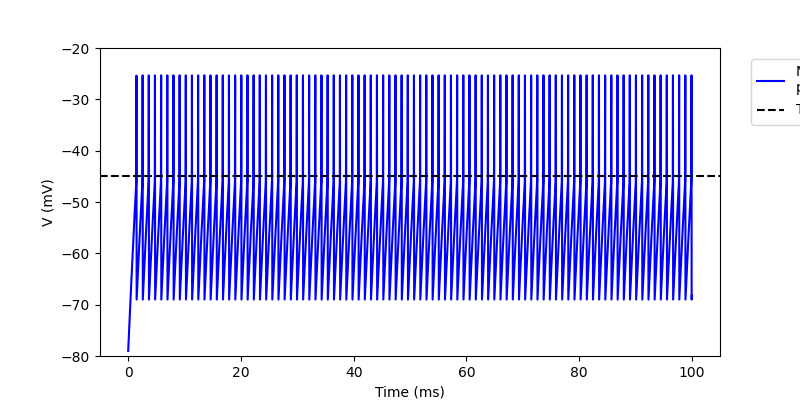

In [20]:
LIF.plot_volt_trace(v, sp)
plt.show()

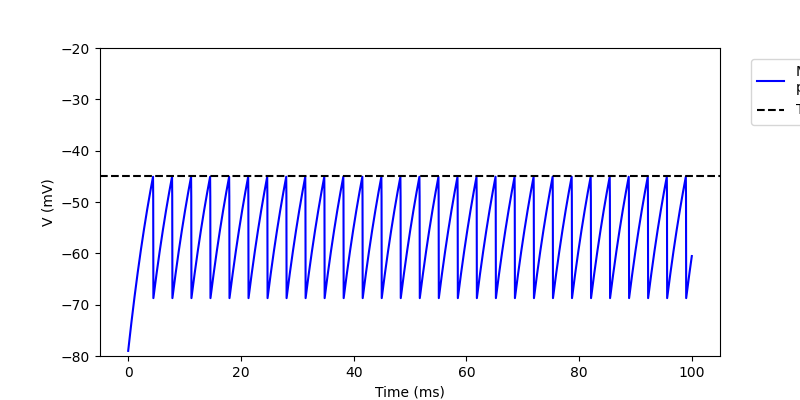

In [21]:
v, sp = LIF.ALIF(2000)
LIF.plot_volt_trace(v, sp)
plt.show()

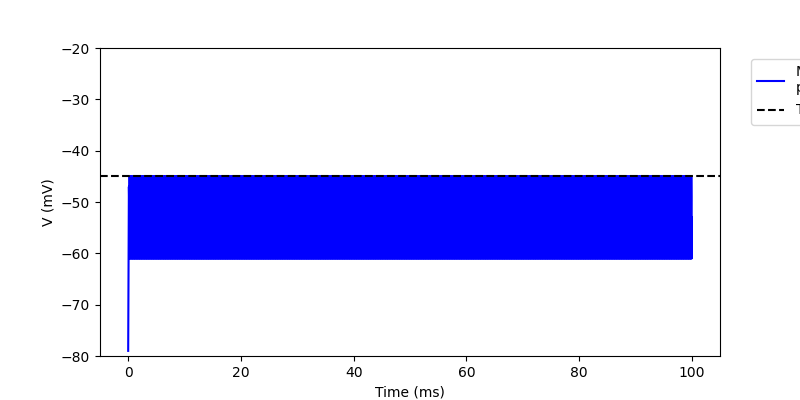

In [22]:
v, sp = LIF.AELIF(2000)
LIF.plot_volt_trace(v, sp)
plt.show()

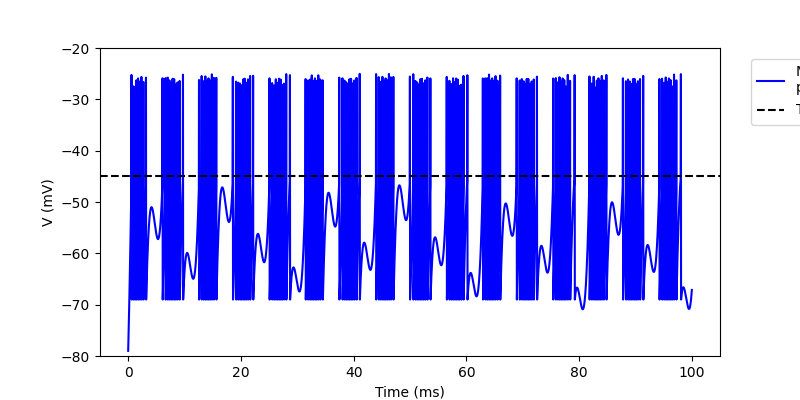

In [23]:
v, sp = LIF.LIF(Iinj1=lambda x: 4000*(np.sin(x)+0.9))
LIF.plot_volt_trace(v, sp)
plt.show()

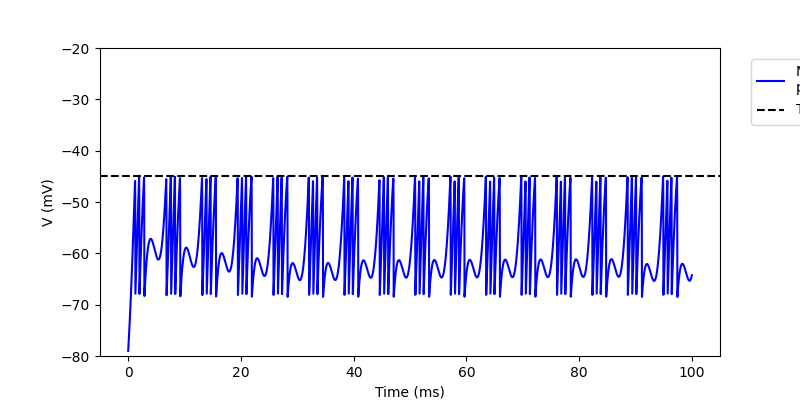

In [24]:
v, sp = LIF.ALIF(Iinj1=lambda x: 4000*(np.sin(x)+0.9))
LIF.plot_volt_trace(v, sp)
plt.show()

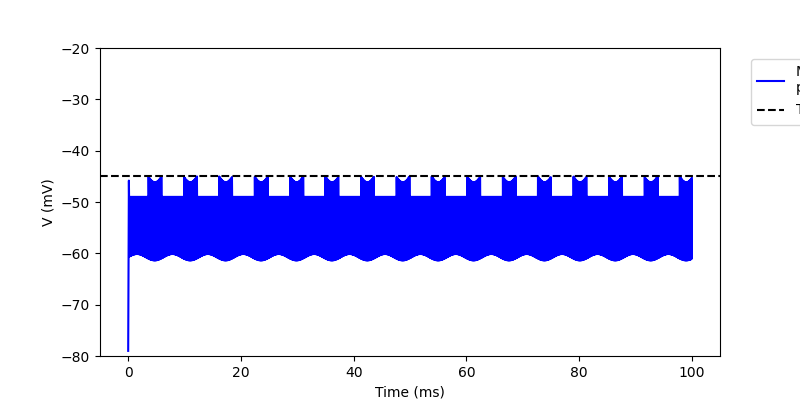

In [25]:
v, sp = LIF.AELIF(Iinj1=lambda x: 4000*(np.sin(x)+0.9))
LIF.plot_volt_trace(v, sp)
plt.show()

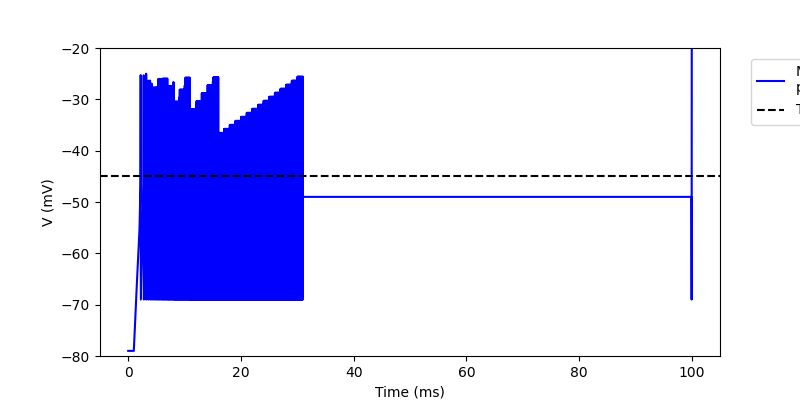

In [26]:
v, sp = LIF.LIF(Iinj1=lambda x: 2000*(np.floor(x)))
LIF.plot_volt_trace(v, sp)
plt.show()

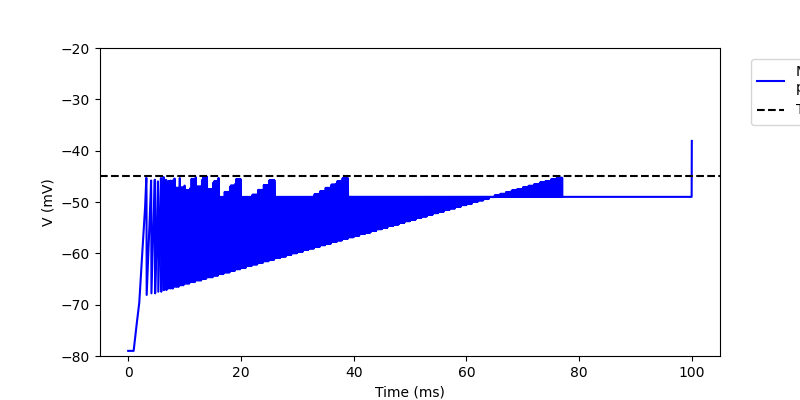

In [27]:
v, sp = LIF.ALIF(Iinj1=lambda x: 2000*(np.floor(x)))
LIF.plot_volt_trace(v, sp)
plt.show()

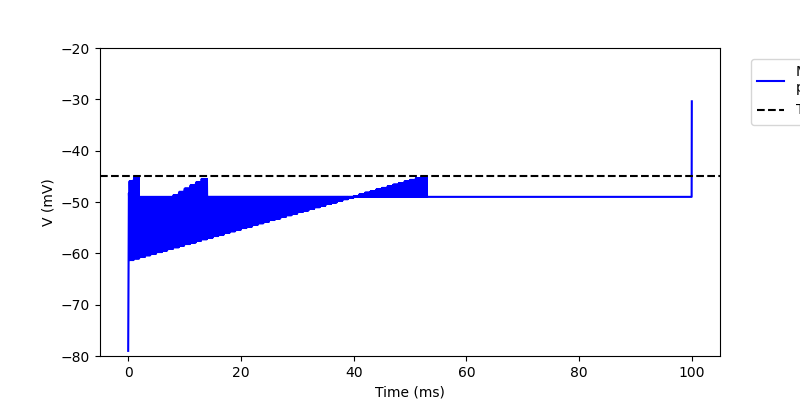

In [28]:
v, sp = LIF.AELIF(Iinj1=lambda x: 2000*(np.floor(x)))
LIF.plot_volt_trace(v, sp)
plt.show()

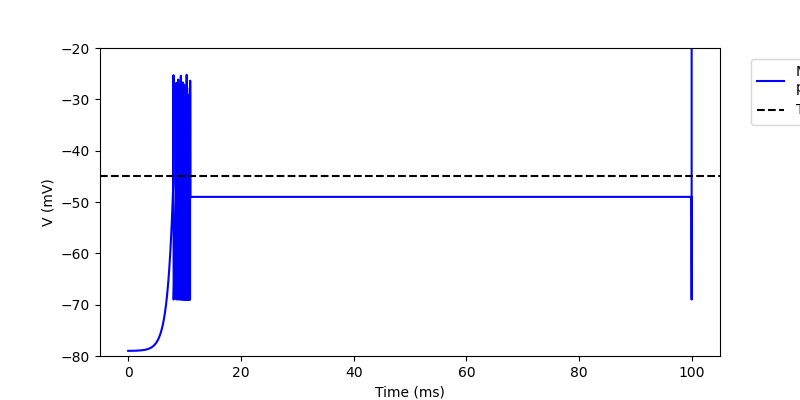

In [29]:
v, sp = LIF.LIF(Iinj1=lambda x: np.exp(x))
LIF.plot_volt_trace(v, sp)
plt.show()

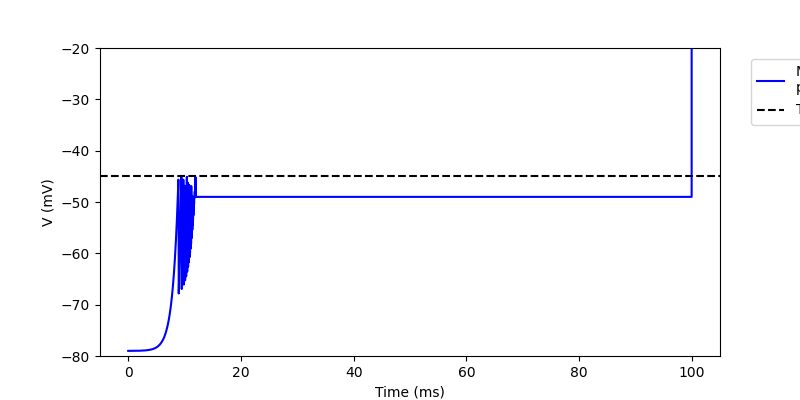

In [30]:
v, sp = LIF.ALIF(Iinj1=lambda x: np.exp(x))
LIF.plot_volt_trace(v, sp)
plt.show()

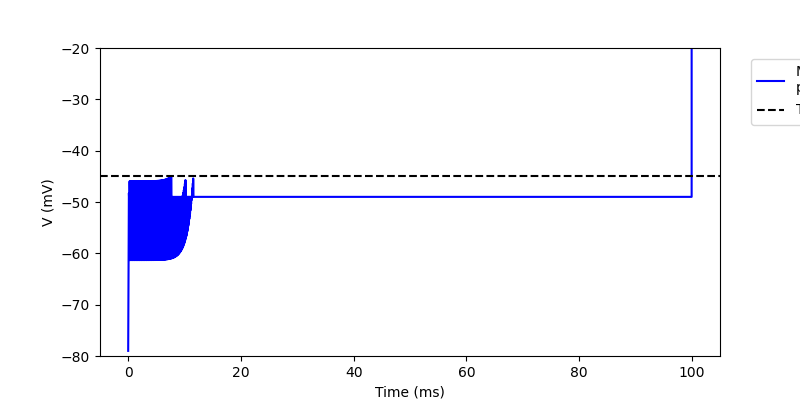

In [31]:
v, sp = LIF.AELIF(Iinj1=lambda x: np.exp(x))
LIF.plot_volt_trace(v, sp)
plt.show()

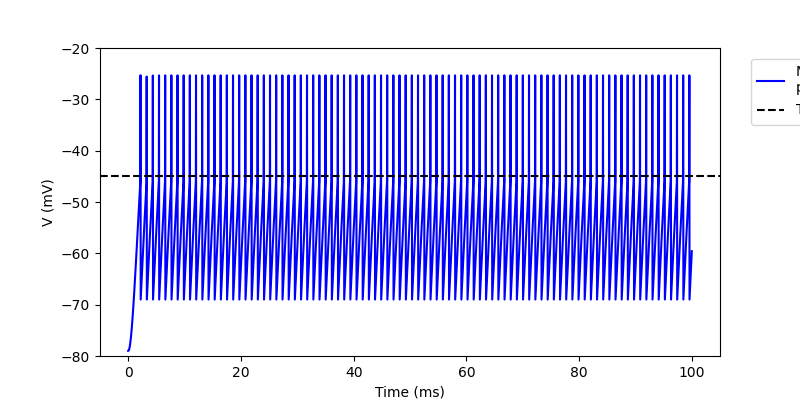

In [32]:
v, sp = LIF.LIF(Iinj1=lambda x: 2000*(np.tanh(x)))
LIF.plot_volt_trace(v, sp)
plt.show()

<ipython-input-18-7f25fd090d22>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8, 4))


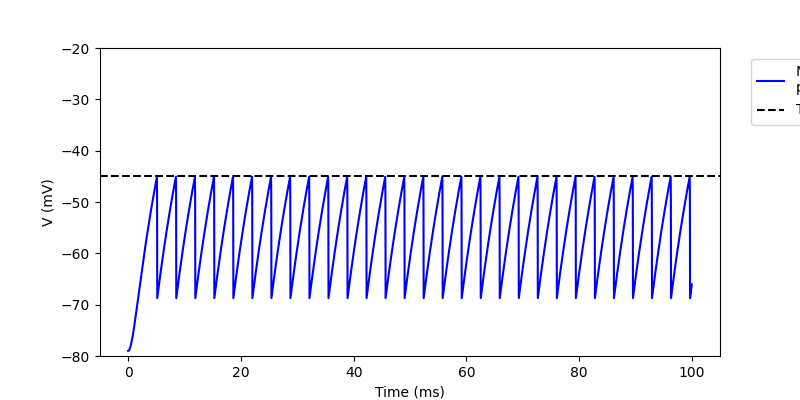

In [33]:
v, sp = LIF.ALIF(Iinj1=lambda x: 2000*(np.tanh(x)))
LIF.plot_volt_trace(v, sp)
plt.show()

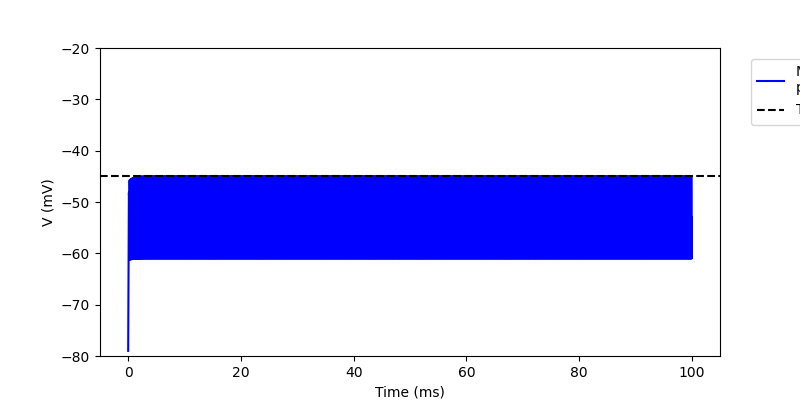

In [34]:
v, sp = LIF.AELIF(Iinj1=lambda x: 2000*(np.tanh(x)))
LIF.plot_volt_trace(v, sp)
plt.show()